In [1]:

# Install required libraries if not already installed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
#Load your dataset
df = pd.read_csv('global_air_quality_data_10000.csv')

#preview the first few rows of the dataset
print("First five rows of the original dataset:")
print(df.head())


# Filter for Johannesburg data and clean
df.columns = [col.lower().strip() for col in df.columns]
df = df[df['city'].str.lower() == 'johannesburg']
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Keep only date and PM2.5, remove missing values
df = df[['date', 'pm2.5']].dropna()

# Group by date and compute daily mean
df = df.groupby(df['date'].dt.date)['pm2.5'].mean().reset_index()
df.columns = ['date', 'pm25']

# Print cleaned dataset
print("\nCleaned Johannesburg dataset preview:")
print(df.head())


First five rows of the original dataset:
             City   Country        Date   PM2.5    PM10    NO2    SO2    CO  \
0         Bangkok  Thailand  2023-03-19   86.57   25.19  99.88  30.63  4.46   
1        Istanbul    Turkey  2023-02-16   50.63   97.39  48.14   8.71  3.40   
2  Rio de Janeiro    Brazil  2023-11-13  130.21   57.22  98.51   9.92  0.12   
3          Mumbai     India  2023-03-16  119.70  130.52  10.96  33.03  7.74   
4           Paris    France  2023-04-04   55.20   36.62  76.85  21.85  2.00   

       O3  Temperature  Humidity  Wind Speed  
0   36.29        17.67     59.35       13.76  
1  144.16         3.46     67.51        6.36  
2  179.31        25.29     29.30       12.87  
3   38.65        23.15     99.97        7.71  
4   67.09        16.02     90.28       14.16  

Cleaned Johannesburg dataset preview:
         date     pm25
0  2023-01-01   71.110
1  2023-01-02   33.185
2  2023-01-04   64.300
3  2023-01-05  112.810
4  2023-01-06  108.200


In [4]:

# Prepare and scale data
df = df.sort_values('date')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['pm25']])

# Create sequences for LSTM input
def create_sequences(data, window_size=14):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

#Train-test split (80/20)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [5]:

# Build and train LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)


Epoch 1/100


/opt/anaconda3/envs/pm25_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2525 - val_loss: 0.2025
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1219 - val_loss: 0.0670
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0704 - val_loss: 0.0446
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0591 - val_loss: 0.0454
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0581 - val_loss: 0.0449
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0582 - val_loss: 0.0427
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 - val_loss: 0.0463
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0588 - val_loss: 0.0437
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0628 - val_loss: 0.0445
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577 - val_loss: 0.0435
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - val_loss: 0.0431
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0582 - val_l

In [6]:

# Make predictions and evaluate
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)

print(f'Model Performance:')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Model Performance:
RMSE: 31.41
MAE: 26.22


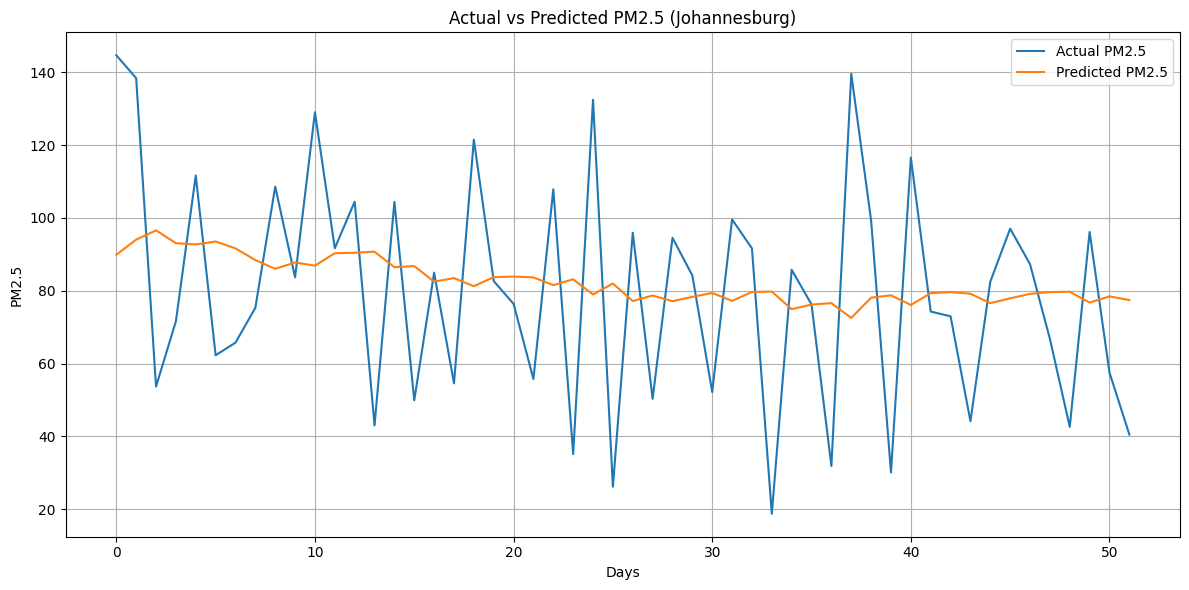

In [7]:
#Visualise results
# 1. Line plot: Actual vs Predicted PM2.5
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual PM2.5')
plt.plot(y_pred, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (Johannesburg)')
plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


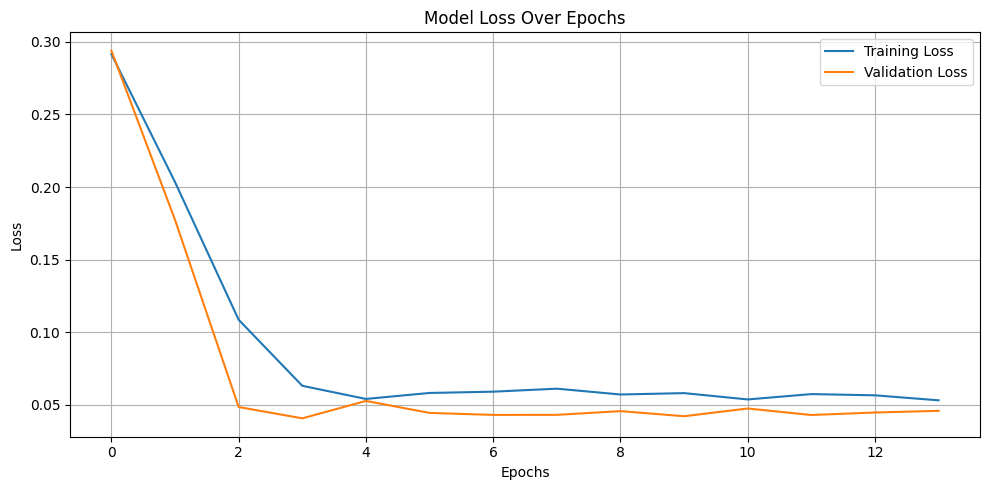

In [27]:
# 2. Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

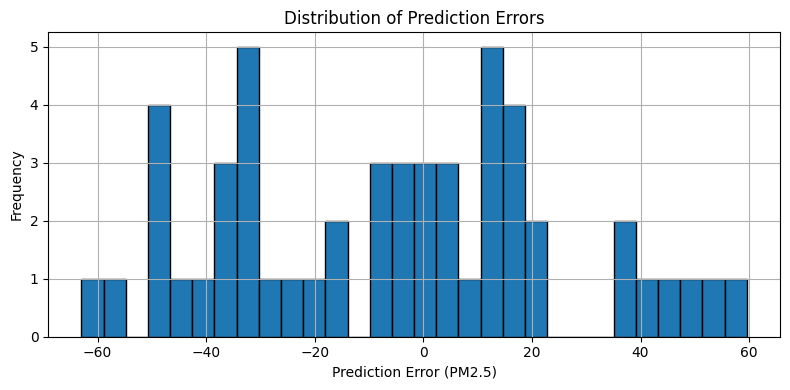

In [26]:
# 3.Histogram of prediction errors
errors = y_actual - y_pred
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (PM2.5)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()